## IMPORT + EXTRACT DATASETS

In [1]:
import numpy as np
import pandas as pd

# binary classification dataset
data_b = pd.read_csv('data_bc.csv')
X_b = data_b.drop('class', axis=1)
y_b = data_b['class'].map({"<=50K": 0, ">50K": 1})   # binary encoding

# multiclass classification dataset
data_m = pd.read_csv('data_mc.csv')
X_m = data_m.drop('age_group', axis=1)
y_m = data_m['age_group']

## HELPER FUNCTION FOR TUNING HYPERPARAMS, TRAINING USING OPTIMAL HYPERPARAMS, EVALUATING TEST PERFORMANCE

In [2]:
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import time

def tune_train_plot(X_train, X_test, y_train, y_test, pipeline, param_grid, cv, hyperparam, logscaled=False, export=False, model=None):

    # array for storing train+test performance
    runtime_performance = []
    
    # create GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv, 
        scoring='accuracy',
        n_jobs=-1
    )

    # fit model
    grid_search.fit(X_train, y_train)

    # extract cross-validation results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # extract parameter values (assumes only 1 hyperparameter tuned)
    param_name = list(param_grid.keys())[0]  # e.g., 'knn__n_neighbors'
    param_values = results[f'param_{param_name}'].values
    mean_scores = results['mean_test_score'].values
    std_scores = results['std_test_score'].values

    # plot with error bars
    plt.figure(figsize=(8, 5))
    plt.errorbar(param_values, mean_scores, yerr=std_scores, fmt='-o', capsize=5)
    plt.xlabel(param_name)
    plt.ylabel('Mean CV Accuracy')
    plt.title(f"Cross-Validation Performance vs {hyperparam}")
    if logscaled:
        plt.xscale('log')  # optional if parameter spans orders of magnitude
    plt.grid(True)
    if export:
        plt.savefig(f"crossvalperformance_{model}.png")
    else:
        plt.show()

    # return best parameters and score
    print("Best hyperparameters:", grid_search.best_params_)
    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

    # create model using tuned hyperparams
    model = clone(pipeline)
    model.set_params(**grid_search.best_params_)

    # train model on training data
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    # predict on training data 
    y_pred = model.predict(X_train)
    training_runtime = end_time - start_time
    runtime_performance.append(training_runtime)
    
    # report training accuracy + performance
    training_acc = accuracy_score(y_train, y_pred)
    runtime_performance.append(training_acc)
    print(f"Training Accuracy: {training_acc:.4f}")
    print(f"Training Runtime (s): {training_runtime:.2f}")

    # predict on test data
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    testing_runtime = end_time - start_time
    runtime_performance.append(testing_runtime)

    # report test accuracy + performance
    testing_acc = accuracy_score(y_test, y_pred)
    runtime_performance.append(testing_acc)
    print(f"Test Accuracy: {testing_acc:.4f}")
    print(f"Test Prediction Runtime (s): {testing_runtime:.2f}")

    return runtime_performance

In [3]:
# train+test split

from sklearn.model_selection import train_test_split

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42, stratify=y_b)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42, stratify=y_m)

# export training and testing sets
training_set = X_train_b.copy()
training_set['class'] = y_train_b.values
training_set.to_csv('trainingset_binary.csv', index=False)

validation_set = X_test_b.copy()
validation_set['class'] = y_test_b.values
validation_set.to_csv('testingset_binary.csv', index=False)

training_set = X_train_m.copy()
training_set['class'] = y_train_m.values
training_set.to_csv('trainingset_multiclass.csv', index=False)

validation_set = X_test_m.copy()
validation_set['class'] = y_test_m.values
validation_set.to_csv('testingset_multiclass.csv', index=False)

In [4]:
# pre-processing pipeline

# begin with identification of categorical and numerical features to correctly preprocess
cat_cols_b = X_train_b.select_dtypes(include=['object']).columns
num_cols_b = X_train_b.select_dtypes(exclude=['object']).columns
cat_cols_m = X_train_m.select_dtypes(include=['object']).columns
num_cols_m = X_train_m.select_dtypes(exclude=['object']).columns

# create pre-processing pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor_b = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_b),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols_b)
    ]
)

preprocessor_m = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_m),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols_m)
    ]
)

In [5]:
# general pipeline w/ model, no params
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# KNN pipeline
pipeline_KNN_b = Pipeline(steps=[
            ('preprocessor', preprocessor_b),
            ('knn', KNeighborsClassifier())
        ])

pipeline_KNN_m = Pipeline(steps=[
            ('preprocessor', preprocessor_m),
            ('knn', KNeighborsClassifier())
        ])

# SVM pipeline
pipeline_SVM_b = Pipeline(steps=[
            ('preprocessor', preprocessor_b),
            ('svm', SVC())
        ])

pipeline_SVM_m = Pipeline(steps=[
            ('preprocessor', preprocessor_m),
            ('svm', SVC())
        ])

# ANN (MLP) pipeline
pipeline_ANN_b = Pipeline(steps=[
            ('preprocessor', preprocessor_b),
            ('ann', MLPClassifier())
        ])

pipeline_ANN_m = Pipeline(steps=[
            ('preprocessor', preprocessor_m),
            ('ann', MLPClassifier())
        ])

# RF pipeline 
pipeline_RF_b = Pipeline(steps=[
            ('preprocessor', preprocessor_b),
            ('rf', RandomForestClassifier())
        ])

pipeline_RF_m = Pipeline(steps=[
            ('preprocessor', preprocessor_m),
            ('rf', RandomForestClassifier())
        ])

In [6]:
# hyperparameter tuning (using same for binary + multiclass tasks)
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# initialize 5 fold cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### KNN
# hyperparameter tuning over number of neighbors (k)
param_grid_KNN = {
    "knn__n_neighbors": list(range(1, 21))  # k = 1 to 20
}

### SVM
# hyperparameter tuning over kernel type
param_grid_SVM = {
    'svm__kernel': ['rbf', 'linear', 'poly']  # trying rbf, linear, and polynomial kernels
}

### ANN
# hyperparameter tuning over the learning rate
param_grid_ANN = {
    'ann__learning_rate_init': np.logspace(-5, -1, 10)  # 10 logarithmically spaced learning rates from 0.00001 to 0.1
}

### RF
# hyperparameter tuning over the number of trees generated
param_grid_RF = {
    'rf__n_estimators': [10, 50, 100, 200, 300, 400, 500, 600]
}

## BINARY CLASSIFICATION

Best hyperparameters: {'knn__n_neighbors': 18}
Best CV accuracy: 0.8429
Training Accuracy: 0.8555
Training Runtime (s): 0.27
Test Accuracy: 0.8396
Test Prediction Runtime (s): 42.43


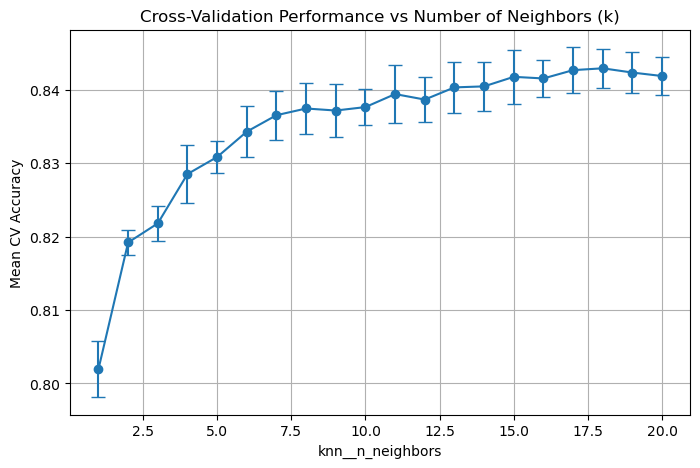

In [7]:
# KNN
results_KNN_b = tune_train_plot(X_train_b, X_test_b, y_train_b, y_test_b, pipeline_KNN_b, param_grid_KNN, cv, "Number of Neighbors (k)", export=True, model="KNN_b")

Best hyperparameters: {'svm__kernel': 'rbf'}
Best CV accuracy: 0.8527
Training Accuracy: 0.8587
Training Runtime (s): 115.48
Test Accuracy: 0.8454
Test Prediction Runtime (s): 11.33


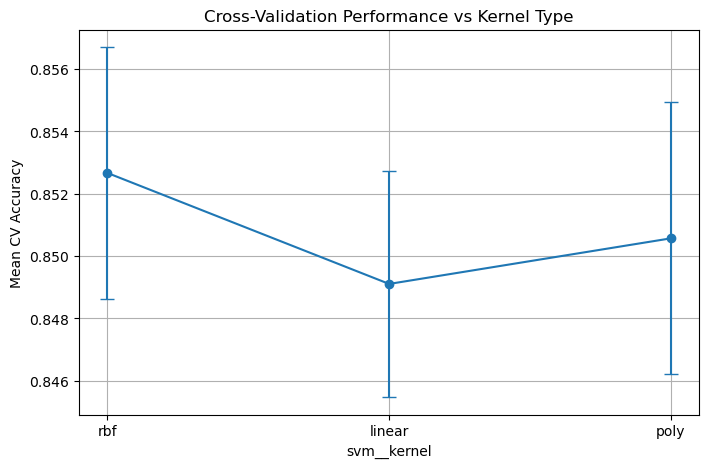

In [8]:
# SVM
results_SVM_b = tune_train_plot(X_train_b, X_test_b, y_train_b, y_test_b, pipeline_SVM_b, param_grid_SVM, cv, "Kernel Type", export=True, model="SVM_b")

Best hyperparameters: {'ann__learning_rate_init': 2.782559402207126e-05}
Best CV accuracy: 0.8520
Training Accuracy: 0.8529
Training Runtime (s): 55.72
Test Accuracy: 0.8499
Test Prediction Runtime (s): 0.15


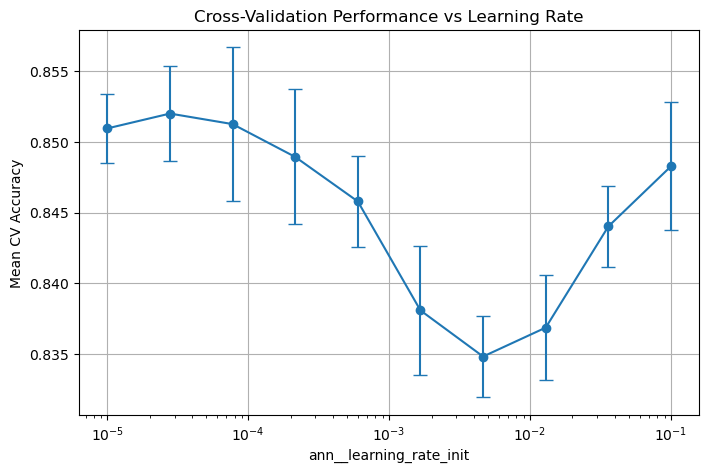

In [9]:
# ANN
results_ANN_b = tune_train_plot(X_train_b, X_test_b, y_train_b, y_test_b, pipeline_ANN_b, param_grid_ANN, cv, "Learning Rate", logscaled=True, export=True, model="ANN_b")

Best hyperparameters: {'rf__n_estimators': 600}
Best CV accuracy: 0.8480
Training Accuracy: 0.9312
Training Runtime (s): 473.84
Test Accuracy: 0.8465
Test Prediction Runtime (s): 1.57


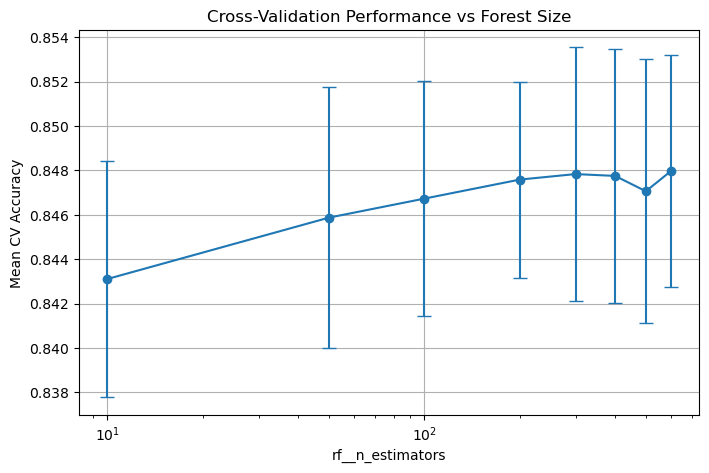

In [10]:
# RF
results_RF_b = tune_train_plot(X_train_b, X_test_b, y_train_b, y_test_b, pipeline_RF_b, param_grid_RF, cv, "Forest Size", logscaled=True, export=True, model="RF_b")

## MULTICLASS CLASSIFICATION

Best hyperparameters: {'knn__n_neighbors': 20}
Best CV accuracy: 0.6005
Training Accuracy: 0.6379
Training Runtime (s): 0.26
Test Accuracy: 0.6043
Test Prediction Runtime (s): 46.68


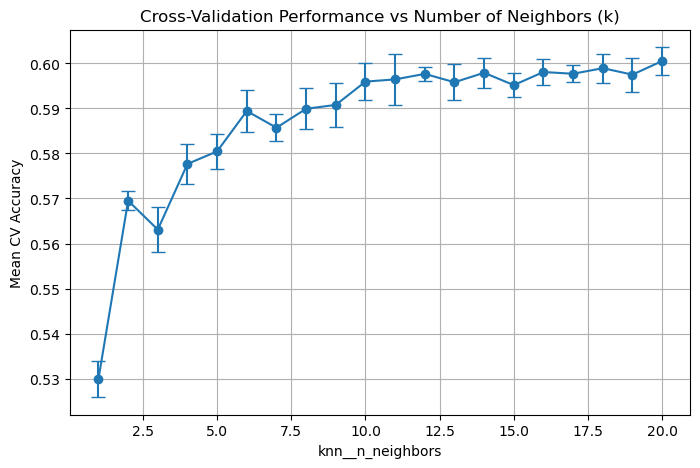

In [11]:
# KNN
results_KNN_m = tune_train_plot(X_train_m, X_test_m, y_train_m, y_test_m, pipeline_KNN_m, param_grid_KNN, cv, "Number of Neighbors (k)", export=True, model="KNN_m")

Best hyperparameters: {'svm__kernel': 'rbf'}
Best CV accuracy: 0.6200
Training Accuracy: 0.6370
Training Runtime (s): 180.56
Test Accuracy: 0.6220
Test Prediction Runtime (s): 29.31


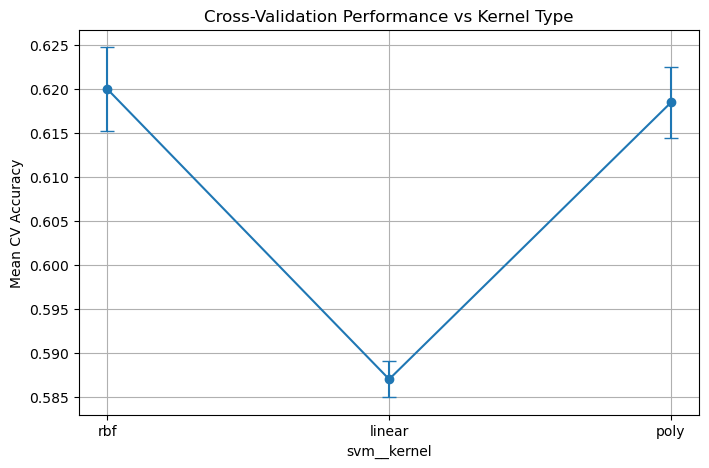

In [12]:
# SVM
results_SVM_m = tune_train_plot(X_train_m, X_test_m, y_train_m, y_test_m, pipeline_SVM_m, param_grid_SVM, cv, "Kernel Type", export=True, model="SVM_m")

Best hyperparameters: {'ann__learning_rate_init': 2.782559402207126e-05}
Best CV accuracy: 0.6245
Training Accuracy: 0.6323
Training Runtime (s): 70.78
Test Accuracy: 0.6245
Test Prediction Runtime (s): 0.07


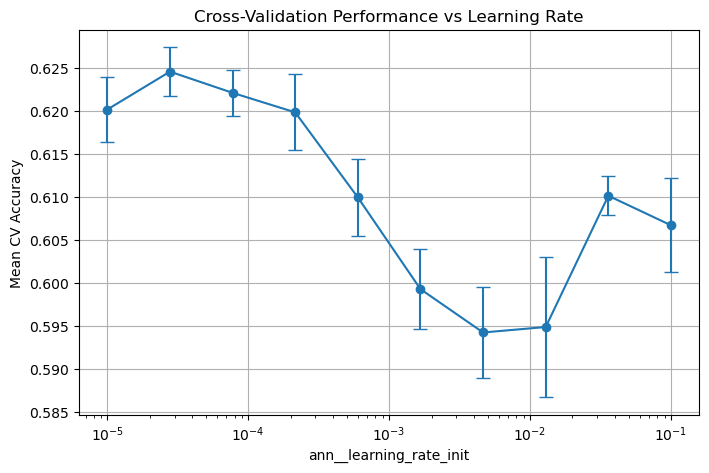

In [13]:
# ANN
results_ANN_m = tune_train_plot(X_train_m, X_test_m, y_train_m, y_test_m, pipeline_ANN_m, param_grid_ANN, cv, "Learning Rate", logscaled=True, export=True, model="ANN_m")

Best hyperparameters: {'rf__n_estimators': 300}
Best CV accuracy: 0.5824
Training Accuracy: 0.8398
Training Runtime (s): 482.66
Test Accuracy: 0.5930
Test Prediction Runtime (s): 2.32


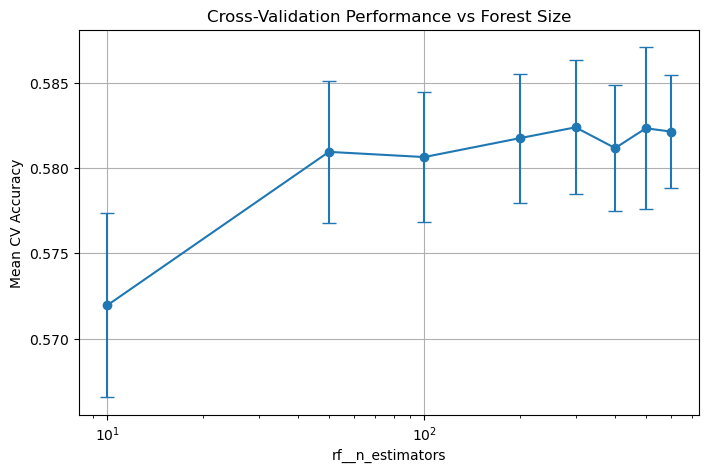

In [14]:
# RF
results_RF_m = tune_train_plot(X_train_m, X_test_m, y_train_m, y_test_m, pipeline_RF_m, param_grid_RF, cv, "Forest Size", logscaled=True, export=True, model="RF_m")